# 步骤：
    1.使用torchvision加载并预处理CIFAR-10数据集
    2.定义网络、损失函数和优化器
    3.训练网络并更新参数
    4.测试
    

## 加载并预处理CIFAR-10数据集(利用CPU)

In [1]:
import torchvision as tv
import torch as t
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
#把Tensor转成image，可视化操作
show = ToPILImage()

In [2]:
#定义对数据的预处理
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

#训练集
trainset = tv.datasets.CIFAR10(root='./CIFAR10',
                               train=True,
                               download=False,
                               transform=transform
                              )

trainloader = t.utils.data.DataLoader(trainset,
                                      batch_size=4,
                                      shuffle=True,
                                      num_workers=2
                                     )

#测试集
testset = tv.datasets.CIFAR10('./CIFAR10',
                              train=False,
                              download=False,
                              transform=transform
                            )
testloader = t.utils.data.DataLoader(testset,
                                     batch_size=4,
                                     shuffle=True,
                                     num_workers=2
                                    )

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')




ship


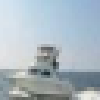

In [3]:
(data, label) = trainset[100]
print(classes[label])
show((data + 1) / 2).resize((100,100)) #还原被归一化的数据

   truck         car       plane       horse


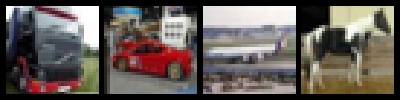

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('    '.join('%8s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid((images + 1) / 2)).resize((400,100))

In [5]:
#第二种呈现形式

import numpy as np
import matplotlib.pyplot as plt

def imshow(img):
    img = (img + 1) /2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('  '.join('%9s'%classes[labels[j]] for j in range(4)))
imshow(tv.utils.make_grid(images))

     ship       frog      horse      horse


<Figure size 640x480 with 1 Axes>

## 定义网络、损失函数和优化器

In [6]:
#定义网络

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        #x = x.view(x.size()[0], -1)    #等价于下式
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x
net = Net()
print (net)
        

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=10, bias=True)
)


In [7]:
#损失函数、优化器

from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 训练网络

In [8]:
for epoch in range(2):
    
    running_loss = 0.0
    for i ,data in enumerate(trainloader, 0):
        #输入数据
        inputs, labels = data
        #梯度清零
        optimizer.zero_grad()
        
        #forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #打印log信息
        running_loss += loss.item()
        #每2000个batch打印一次训练状态
        if i % 2000 == 1999:
            print('[%d, %4d] loss:%.3f'%(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0
print('Finished Training')
    

[1, 2000] loss:2.283
[1, 4000] loss:2.098
[1, 6000] loss:1.901
[1, 8000] loss:1.767
[1, 10000] loss:1.603
[1, 12000] loss:1.521
[2, 2000] loss:1.441
[2, 4000] loss:1.405
[2, 6000] loss:1.375
[2, 8000] loss:1.361
[2, 10000] loss:1.332
[2, 12000] loss:1.279
Finished Training


实际的label
     cat       horse       horse         car


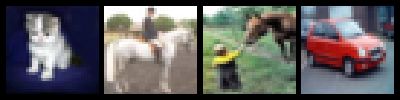

In [9]:
dateiter = iter(testloader)
images, labels = dateiter.next()
print('实际的label')
print('    '.join('%8s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid((images.data.cpu()+1)/2)).resize((400,100))

In [10]:
#计算图片在每个类别上的分数
outputs = net(images)

#得分最高的那个类
_, precdicted = t.max(outputs, 1)
print('预测结果:',' '.join('%5s' %classes[precdicted[j]] for j in range(4)))

预测结果:   cat horse  deer   car


In [11]:
#计算整体准确率
correct = 0 
total = 0
for data in testloader:
    images, labels = data
    outputs = net(images)
    _, precdicted = t.max(outputs, 1)
    total += labels.data[0]
    correct += (precdicted == labels).sum()
    
print('10000张测试集中的准确率为： %d%%'%(100 * correct / total))

10000张测试集中的准确率为： 48%


In [12]:
#计算各个类别准确率
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with t.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = t.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('%5s 的准确率为：%2d %%'%((classes[i]), 100*class_correct[i]/class_total[i]))

plane 的准确率为：37 %
  car 的准确率为：75 %
 bird 的准确率为：43 %
  cat 的准确率为：34 %
 deer 的准确率为：47 %
  dog 的准确率为：54 %
 frog 的准确率为：75 %
horse 的准确率为：49 %
 ship 的准确率为：78 %
truck 的准确率为：57 %
